In [1]:
import simpy 
import random
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import make_interp_spline
from sklearn.mixture import GaussianMixture
import warnings

In [2]:
# Constants
LOG_FILE = 'logs/ev_simulation.log'
QA_FOLDER = 'qa/'

# Configure warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in multiply")

# Configure plotting style
plt.style.use('seaborn-v0_8')

In [3]:
# Data

# Vehicle models
vehicle_models = {
        'Model': ['S', 'M', 'L', 'XL'],
        'Capacity': [55, 75, 95, 120],
        'Efficiency': [0.17, 0.18, 0.19, 0.20],
        'Share': [0.6, 0.2, 0.15, 0.5]
    }
vehicle_df = pd.DataFrame(vehicle_models)

# Charger models
charger_models = {
  'kWh': [20, 50, 150]
}

# GMM of CA weekday traffic patterns
gmm_df = pd.read_csv('data/traffic_ca_2020.csv')
GMM = GaussianMixture(n_components=2)
GMM.fit(gmm_df.values)

GaussianMixture(n_components=2)

In [4]:
## Classes: Parameters, Drivers, Stations and Chargers

In [5]:
class SimulationParameters:
  """Default simulation parameters."""
  def __init__(self):
      self.sim_duration = 7 * 24 * 60 
      self.num_epochs = 1
      self.num_drivers = 5
      self.num_stations = 5
      self.num_chargers = 5
      self.loc_destination = 616 # km (SF to LA = 616.2)
      self.avg_speed = 104.585 # km/h (65 mph * 1.609)
      self.trip_time_tolerance = 0.25 # trip time allowance % for charging vs. nonstop
      self.log_enabled = False

  def get_params():
    """Return all parameters as a dictionary."""
    instance = SimulationParameters()
    params = vars(instance)
    for param, value in params.items():
        print(f"{param}: {value}")

In [6]:
class ChargingNetwork:
  """Represents the network of charging stations."""
  instances = []
  def __init__(self, stations):
      self.stations = stations
      ChargingNetwork.instances.append(self)
  
  def get_station(self, station_loc):
    """Get a station at a specific location."""
    for station in self.stations:
      if station.location == station_loc:
        return station
  
  def reserve_charger(self, station, charge_amount):
    """Reserve a charger at a specific station."""
    return station.reserve_charger(charge_amount)
    

In [7]:
class ChargingStation:
  """Represents a charging station."""
  instances = []
  def __init__(self, env, id, location, chargers):
      self.env = env
      self.id = id
      self.location = location
      self.chargers = chargers
      self.visits = 0
      self.charge_time = 0
      self.queue_time = 0
      ChargingStation.instances.append(self)

  def get_earliest_charger(self):
    """Get the charger that will be available the earliest."""
    return sorted(self.chargers, key=lambda c: (-c.charging_speed, c.release_time))[0]
   
  def reserve_charger(self, charge_amount):
    """Reserve a charger and update its release time."""
    charger = self.get_earliest_charger()
    charge_time = charge_amount / charger.charging_speed * 60 # minutes
    charger.update_release_time(charge_time) 
    return charger.request()

  def delete_all():
    """Delete all instances of ChargingStation."""
    while ChargingStation.instances:
        instance = ChargingStation.instances.pop()
        del instance

In [8]:
class Charger(simpy.Resource):
  """Represents a charger at a charging station."""
  def __init__(self, env, id, charging_speed, release_time):
    super().__init__(env, capacity=1)
    self.id = id
    self.charging_speed = charging_speed
    self.release_time = release_time

  def update_release_time(self, charging_time):
    """Update the release time of the charger."""
    self.release_time = max(self.release_time, self._env.now) + charging_time

In [9]:
class Driver:
  """Represents a driver in the simulation."""
  instances = []

  def __init__(self, env, id, station_list, charging_network, avg_speed, loc_destination, model, battery_capacity, efficiency, battery_level):
      self.env = env
      self.id = id
      self.station_list = station_list
      self.charging_network = charging_network
      self.avg_speed = avg_speed
      self.loc_destination = loc_destination
      self.model = model
      self.battery_capacity = battery_capacity # kWh
      self.efficiency = efficiency # kWh/km
      self.battery_level = battery_level # kWh
      self.avg_rate = self.avg_speed/60  # km/m
      self.loc_current = 0
      self.mileage = 0
      self.queue_time = 0
      self.charge_time = 0
      self.charges = 0
      self.trip_start_time = 0
      self.trip_end_time = 0
      self.trip_time = 0
      self.db = 0
      self.num_stations = 0
      Driver.instances.append(self)
     
  def drive_cycle(self):
    """Simulate the driving cycle of the driver."""
    # trip start vars
    self.trip_start_time = generate_trip_start_time(GMM,1) * 60

    yield self.env.timeout(self.trip_start_time)
    driver_log_msg(self, (f"Started trip in {self.model} with {self.battery_capacity} kWh battery"))
    
    stations_arr = np.array(self.station_list)
    self.num_stations = len(stations_arr) # for params sweep tracking

    while self.loc_current < self.loc_destination:

        # max distance on current battery level
        drive_distance_max = self.battery_level / self.efficiency
        
        # if final destination reachable, go there
        if self.loc_destination < self.loc_current + drive_distance_max:
            dest = self.loc_destination 
            station = None
        else:
            # if not, find next best station
            station_dist_arr = self.loc_current + drive_distance_max - stations_arr
            station_dist_arr[stations_arr < self.loc_current] = np.inf # only ahead of current position
            station_dist_arr[station_dist_arr < 0] = np.inf # only reachable on current battery level
            dest = stations_arr[np.argmin(station_dist_arr)] # furthest reachable station

            if dest > 0:
                station = self.charging_network.get_station(dest)
            else:
                # if no station reachable, go max distance and trigger 'dead battery' error
                dest = drive_distance_max 
                station = None

        # drive  
        drive_distance = dest - self.loc_current
        drive_time = abs(drive_distance) / self.avg_speed * 60 # minutes
        
        yield self.env.timeout(drive_time) # driving time
        
        self.trip_time += drive_time # adjust trip time
        self.loc_current += drive_distance # adjust location
        self.mileage += abs(drive_distance) # add mileage
        self.battery_level -= abs(drive_distance) * self.efficiency # adjust battery level
        driver_log_msg(self, "completed leg")

        if station:
            # reserve available charger
            charge_amount = self.battery_capacity - self.battery_level
            charger_request = self.charging_network.reserve_charger(station, charge_amount)

            driver_log_msg(self, f"started queue for charger")
            queue_start = self.env.now

            with charger_request as req:

                yield req 
                charger = req.resource
                self.charges += 1
                station.visits += 1
                self.battery_level = self.battery_capacity # 100% charge
              
                charge_time = charge_amount / charger.charging_speed * 60 # in minutes
                self.charge_time += charge_time
                self.trip_time += charge_time
                station.charge_time += charge_time

                queue_time = (self.env.now - queue_start) if (self.env.now - queue_start > charge_time) else 0
                self.queue_time += queue_time
                self.trip_time += queue_time
                station.queue_time += queue_time

                yield self.env.timeout(charge_time)                    
                driver_log_msg(self, f"used charger {charger.id} @ {charger.charging_speed} kwH at station {station.id}")

        elif self.battery_level <= 0:
            self.battery_level = 0
            raise DeadBatteryError(f"Driver {self.id} has a dead battery at location {self.loc_current}")
        
    driver_log_msg(self, "completed trip")

    # trip end metrics
    self.trip_end_time = self.env.now
    self.battery_level_end = self.battery_level

  def run(self):
    """Run the driver's trip."""
    try:
        yield self.env.process(self.drive_cycle())
    except DeadBatteryError as e:
            log_msg(self.env, f"Error: {e}", level=logging.WARNING)
            self.db = 1

  def delete_all():
    """Delete all instances of Driver."""
    while Driver.instances:
        instance = Driver.instances.pop()
        del instance

In [10]:
## Simulation Functions

In [11]:
def run_simulation(params, sweep = False):
  """Run the main simulation"""
  setup_logging(params)
  driver_results_df = pd.DataFrame()
  station_results_df = pd.DataFrame()

  logging.getLogger('EVSimulation').log(level=logging.INFO, msg='## run starting ##')

  try:
    for epoch in range(params.num_epochs):
        
      env = simpy.Environment()
      run_simulation_epoch(env, params)
      env.run(until=params.sim_duration)
  
      driver_epoch_df = get_driver_results()
      driver_epoch_df['epoch'] = epoch+1
      driver_results_df = pd.concat([driver_results_df, driver_epoch_df])
      Driver.delete_all()
  
      station_epoch_df = get_station_results()
      station_epoch_df['epoch'] = epoch+1
      station_results_df = pd.concat([station_results_df, station_epoch_df])
      ChargingStation.delete_all()
  
    driver_metrics_dict = get_driver_metrics(driver_results_df)
    station_metrics_df = get_station_metrics(station_results_df)
                                         
    logging.getLogger('EVSimulation').log(level=logging.INFO, msg='## run complete ##\n\n')
                                         
    return {'driver_results': driver_results_df, 
            'driver_metrics': driver_metrics_dict,
            'station_results': station_results_df,
            'station_metrics': station_metrics_df
          }
  except Exception as e:
        logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
        raise

In [12]:
def run_simulation_epoch(env, params):
  """Run a single epoch of the simulation."""
  log_msg(env, '### epoch starting ###')
  log_msg(env, f"Began simulation with parameters - drivers: {params.num_drivers}, stations: {params.num_stations}, chargers: {params.num_chargers}, destination: {params.loc_destination}, speed: {params.avg_speed}")
  
  # initialize charging station network
  stations = [ChargingStation(env, id = n+1, location = np.round(np.linspace(0,params.loc_destination,params.num_stations),0)[n],
                              chargers=[Charger(env, id = i+1, charging_speed=random.choice(charger_models['kWh']), release_time = i) for i in range(params.num_chargers)]) for n in range(params.num_stations)]

  station_list = sorted([station.location for station in stations])
  log_msg(env, f"Stations at {station_list}")
   
  charging_network = ChargingNetwork(stations)
  
  # initialize drivers and start their trips
  for id in range(params.num_drivers):
      model, battery_capacity, efficiency, battery_level = generate_vehicle()
      driver = Driver(env, id+1, station_list, charging_network, params.avg_speed, params.loc_destination, model, battery_capacity, efficiency, battery_level)
      env.process(driver.run())

In [13]:
def run_simulation_sweep(params):
  """Run a parameter sweep simulation."""
  sweep_results_df = pd.DataFrame()

  for num_stations in range(1, 51):
      params.num_stations = num_stations
      # driver_results_df, driver_metrics_dict, station_results_df = run_simulation(params, sweep = True)
      results_dict = run_simulation(params, sweep = True)
      sweep_results_df = pd.concat([sweep_results_df, results_dict['driver_results']])

  # constraints: no dead batteries, trip time under certain limit, minimum num_stations
  trip_time_limit = params.loc_destination / params.avg_speed * 60 * (1 + params.trip_time_tolerance)
  filter_results_df = sweep_results_df.groupby('num_stations').filter(
      lambda x: x['db'].sum() == 0 and x['trip_time'].mean() <= trip_time_limit)
  min_num_stations = filter_results_df['num_stations'].min()
  min_sweep_results_df = filter_results_df[filter_results_df['num_stations'] == min_num_stations]

  # return optimal params
  sweep_params = params
  setattr(sweep_params, 'num_stations', min_num_stations)

  # sweep_results_df.to_csv('qa/sweep_results_df.csv', index=False) # save for qa
  # min_sweep_results_df.to_csv('qa/min_sweep_results.csv', index=False) # save for qa

  0 if np.isnan(min_num_stations) else min_num_stations
  return {'min_num_stations': min_num_stations, 
          'sweep_results': sweep_results_df,
          'sweep_params': sweep_params}

In [14]:
def generate_vehicle():
  """Generate a random vehicle based on the vehicle models."""
  row = random.choices(vehicle_df['Model'], vehicle_df['Share'])
  model= vehicle_df.loc[vehicle_df['Model'] == row[0]].values[0][0]
  battery_capacity = vehicle_df.loc[vehicle_df['Model'] == row[0]].values[0][1] # kWh
  efficiency = vehicle_df.loc[vehicle_df['Model'] == row[0]].values[0][2] # kWh/km
  battery_level = round(random.uniform(0.6, 1) * battery_capacity,1) # random starting charge level 60-100%
  return(model, battery_capacity, efficiency, battery_level)

In [15]:
def generate_trip_start_time(gmm, num_trips, min_value=0, max_value=24):
    """Generate trip start times from fitted GMM, rejection sampling for valid hours."""
    # orig wrote to handle all samples at once, too computationally expensive
    sample_arr = np.array([])
    
    for i in range(num_trips):
        good_sample = False

        while not good_sample:
            # sample from the new instance
            samples, _ = gmm.sample(1)
            samples = [s[0] for s in samples] # samples only, not the probabilities

            # check if the samples are within the desired range
            good_sample = all([min_value <= s < max_value for s in samples])

        sample_arr = np.append(sample_arr, samples)

    return sample_arr[0]

In [16]:
## Calc Functions

In [17]:
def get_driver_results():
  """Get the results for all drivers in the simulation."""
  data = {
      'num_stations': [], 
      'driver_id': [],
      'model': [],
      'battery_capacity': [],
      'efficiency': [],
      'battery_level_end': [],
      'mileage': [],
      'trip_start_time': [],
      'trip_end_time': [],
      'trip_time': [],
      'queue_time': [],
      'charge_time': [],
      'charges': [],
      'db': []
  }
  for driver in Driver.instances:
      data['num_stations'].append(driver.num_stations)
      data['driver_id'].append(driver.id)
      data['model'].append(driver.model)
      data['battery_capacity'].append(driver.battery_capacity)
      data['efficiency'].append(driver.efficiency)
      data['battery_level_end'].append(driver.battery_level)
      data['trip_start_time'].append(driver.trip_start_time)
      data['trip_end_time'].append(driver.trip_end_time)
      data['trip_time'].append(driver.trip_time)
      data['mileage'].append(driver.mileage)
      data['queue_time'].append(driver.queue_time)
      data['charge_time'].append(driver.charge_time)
      data['charges'].append(driver.charges)
      data['db'].append(driver.db)

  df = pd.DataFrame(data)
  df.to_csv('qa/process_results.csv', index=False) # save for qa
  return df

In [18]:
def get_driver_metrics(df):
  """Calculate metrics from driver results."""
  avg_mileage = df['mileage'].mean()
  avg_trip_time = df['trip_time'].mean()
  max_trip_time = df['trip_time'].max()
  std_trip_time = df['trip_time'].std()
  ci_trip_time = stats.t.interval(0.95, len(df)-1, avg_trip_time, stats.sem(df['trip_time']))
  avg_queue_time = df['queue_time'].mean()
  max_queue_time = df['queue_time'].max()
  std_queue_time = df['queue_time'].std()
  ci_queue_time = stats.t.interval(0.95, len(df)-1, avg_queue_time, stats.sem(df['queue_time']))
  avg_charging_time = df['charge_time'].mean()
  max_charging_time = df['charge_time'].max()
  std_charging_time = df['charge_time'].std()
  ci_charging_time = stats.t.interval(0.95, len(df)-1, avg_queue_time, stats.sem(df['charge_time']))
  avg_dead_batteries =  df['db'].mean()

  dict = {
      'avg_mileage': avg_mileage,
      'avg_trip_time': avg_trip_time,
      'max_trip_time': max_trip_time,
      'std_trip_time': std_trip_time,
      'ci_trip_time': ci_trip_time,
      'avg_queue_time': avg_queue_time,
      'max_queue_time': max_queue_time,
      'std_queue_time': std_queue_time,
      'ci_queue_time': ci_queue_time,
      'avg_charging_time': avg_charging_time,
      'max_charging_time': max_charging_time,
      'std_charging_time': std_charging_time,
      'ci_charging_time': ci_charging_time,
      'avg_dead_batteries': avg_dead_batteries
  }

  dict_rounded = {k: (tuple(round(v,1) for v in value) if isinstance(value, tuple) else round(value,1)) for k, value in dict.items()}
  
  return dict_rounded

In [19]:
def get_station_results():
  """Get the results for all charging stations in the simulation."""
  data = {
      'station_id': [],
      'location': [],
      'visits': [],
      'charge_time': [],
      'queue_time': []
  }
  
  for station in ChargingStation.instances:
      data['station_id'].append(station.id)
      data['location'].append(station.location)
      data['visits'].append(station.visits)
      data['charge_time'].append(station.charge_time)
      data['queue_time'].append(station.queue_time)

  df = pd.DataFrame(data)
  df.to_csv('qa/station_results.csv', index=False) # save for qa
  return df

In [20]:
def get_station_metrics(df):
  """Calculate metrics from station results."""
  df = df.groupby('station_id')[['visits','charge_time','queue_time']].mean()
  df['total_time'] = df['charge_time'] + df['queue_time']
  df['avg_time'] = df['total_time'] / df['visits']
  df['avg_queue_time'] = df['queue_time'] / df['visits']
  df['avg_charge_time'] = df['charge_time'] / df['visits']
  return df

In [21]:
## Graphing Functions

In [22]:
def get_driver_results_plot(df):
  """Generate plots for driver results."""
  fig, axs = plt.subplots(1,3,figsize=(10, 6))

  # Plot the histograms
  axs[0].hist(df['trip_time'], bins=30, color='grey')
  axs[0].set_title('Trip Time')
 
  axs[1].hist(df['queue_time'], bins=30, color='grey')
  axs[1].set_title('Queue Time')
  
  axs[2].hist(df['charge_time'], bins=30, color='grey')
  axs[2].set_title('Charge Time')

  plt.close(fig)
  return fig

In [23]:
def get_station_metrics_plot(df):
  """Generate a plot for station metrics."""
  fig, ax = plt.subplots(figsize=(10, 6))
  ax2 = ax.twinx()
  
  df['visits'].plot(kind='bar', color='grey', ax=ax, position=1)
  df['avg_queue_time'].plot(kind='bar', color='pink', ax=ax2)
  df['avg_charge_time'].plot(kind='bar', color='lightgreen', ax=ax2, bottom=df['avg_queue_time'])

  ax.set_ylabel('Total Visits')
  ax.legend(['Total Visits'], loc='upper left', bbox_to_anchor=(0, 0.918))
  
  ax2.set_title('Average Queue & Charge Time by Station')
  ax2.set_xlabel('Station ID')
  ax2.set_ylabel('Time')
  ax2.legend(['Avg Queue Time', 'Avg Charge Time'], loc='upper left')
  
  ax2.grid(False)

  plt.close(fig)
  return fig

In [24]:
def get_sweep_graphs_plot(df,ax,min_num_stations,xcol,ycol,xlab,ylab,title):
  """Generate a single sweep graph plot."""
  s = df.groupby(xcol)[ycol].mean().reset_index()
  s.columns = ['x','y']
  
  x = s['x']
  y = s['y']
  x_smooth = np.linspace(x.min(), x.max(), 300)
  spl = make_interp_spline(x, y, k=3)
  y_smooth = spl(x_smooth)

  ax.plot(x_smooth, y_smooth)
  ax.scatter(x, y, color='red')  # Optional: also plot the original points
  ax.axvline(x=min_num_stations, color='green', linestyle='--')
  ax.set_title(title)
  # ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.grid(True)

In [25]:
def get_sweep_plots_grid(df,min_num_stations):
  """Generate a grid of sweep plots."""
  fig, axs = plt.subplots(2, 2, figsize=(10, 8))
  get_sweep_graphs_plot(df, axs[0,0], min_num_stations, 'num_stations','trip_time','Num Stations','Mean Trip Time','Mean Trip Times by Num Stations')
  get_sweep_graphs_plot(df, axs[0,1], min_num_stations, 'num_stations','queue_time','Num Stations','Mean Queue Time','Mean Queue Times by Num Stations')
  get_sweep_graphs_plot(df, axs[1,0], min_num_stations, 'num_stations','charge_time','Num Stations','Mean Charge Time','Mean Charge Times by Num Stations')
  get_sweep_graphs_plot(df, axs[1,1], min_num_stations, 'num_stations','db','Num Stations','Dead Battery Pct','Dead Batteries by Num Stations')
  plt.close(fig)
  return fig

In [26]:
## Errors and Logging

In [27]:
class DeadBatteryError(Exception):
    "Raised when the battery level <= 0"
    pass

def setup_logging(params):
    level = logging.INFO if params.log_enabled == True else logging.CRITICAL
    logging.basicConfig(
        filename = 'logs/ev_simulation.log',
        filemode='w', # overwrite log file
        level=level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

def driver_log_msg(driver, message):
    status = "Driver %s [Loc: %.1f Mlg: %.1f Bat: %.1f QueT: %.1f ChgT: %.1f TrpT: %.1f] - %s" % (driver.id, driver.loc_current, driver.mileage, driver.battery_level, driver.queue_time, driver.charge_time, driver.trip_time, message)
    log_msg(driver.env, status)


def log_msg(env, message, level=logging.INFO):
    timestamp = round(env.now, 1)
    logger = logging.getLogger('EVSimulation')
    logger.log(level, f"[{timestamp}] {message}")

In [28]:
## User Functions - use these to run simulations

In [29]:
def run_scenario(**kwargs):
  """Run a single simulation scenario."""
  if 'params' in kwargs:
    params = kwargs['params'] # take a full params object (like sweep_params)
  else:
    params = SimulationParameters() # load defaults and apply kwargs
    for key, value in kwargs.items(): 
        setattr(params, key, value)

  print('Running scenario with these parameters:')

  for param, value in vars(params).items():
      print(f"{param}: {value}")

  results_dict = run_simulation(params)
  results_dict['driver_results_plot'] = get_driver_results_plot(results_dict['driver_results'])
  results_dict['station_metrics_plot'] = get_station_metrics_plot(results_dict['station_metrics'])
  
  return results_dict

In [30]:
def run_sweep(**kwargs):
  """Run a parameter sweep simulation."""
  params = SimulationParameters() # load defaults
  for key, value in kwargs.items():
        setattr(params, key, value)

  print('Running sweep with these parameters:')

  for param, value in vars(params).items():
      print(f"{param}: {value}")

  print('(num_stations will sweep from 1-50)')

  results_dict = run_simulation_sweep(params)
  results_dict['sweep_plots'] = get_sweep_plots_grid(results_dict['sweep_results'], results_dict['min_num_stations'])
  
  return results_dict

In [31]:
######
###### RUN UP TO HERE
######

In [ ]:
# Example 1: Single Scenario

In [ ]:
s1 = run_scenario(num_drivers=50, num_stations=10, num_epochs=5, log_enabled = True)

In [ ]:
s1['driver_results_plot']

In [ ]:
s1['station_metrics_plot']

In [ ]:
s1['driver_metrics']

In [ ]:
# Example 2: Sweep
# Set trip_time_tolerance, and keep num_epochs low

In [32]:
s2 = run_sweep(num_drivers=1000, trip_time_tolerance=0.3, num_epochs=5)

Running sweep with these parameters:
sim_duration: 10080
num_epochs: 5
num_drivers: 1000
num_stations: 5
num_chargers: 5
loc_destination: 616
avg_speed: 104.585
trip_time_tolerance: 0.3
log_enabled: False
(num_stations will sweep from 1-50)


In [33]:
s2['min_num_stations']

nan

In [34]:
s2['sweep_results']

,num_stations,driver_id,model,battery_capacity,efficiency,battery_level_end,mileage,trip_start_time,trip_end_time,trip_time,queue_time,charge_time,charges,db,epoch
0,1,1,XL,120,0.20,0.00,394.500000,781.602899,0.000000,226.323086,0.000000,0.000,0,1,1
1,1,2,M,75,0.18,0.00,611.111111,435.288416,0.000000,350.592022,0.000000,0.000,0,1,1
2,1,3,XL,120,0.20,0.00,458.000000,745.729756,0.000000,262.752785,0.000000,0.000,0,1,1
3,1,4,XL,120,0.20,0.00,1146.000000,664.680969,0.000000,657.455658,0.000000,0.000,0,1,1
4,1,5,M,75,0.18,0.00,312.777778,1061.734979,0.000000,179.439371,0.000000,0.000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,50,996,XL,120,0.20,72.20,616.000000,464.115071,864.911830,400.796759,0.000000,47.400,1,0,5
996,50,997,S,55,0.17,3.66,616.000000,953.677582,1608.449991,654.772409,279.423650,21.952,1,0,5
997,50,998,S,55,0.17,46.50,616.000000,833.574748,1379.447921,541.342980,145.058221,42.888,2,0,5
998,50,999,S,55,0.17,35.79,616.000000,773.047057,1293.545134,517.923759,121.683000,42.844,2,0,5


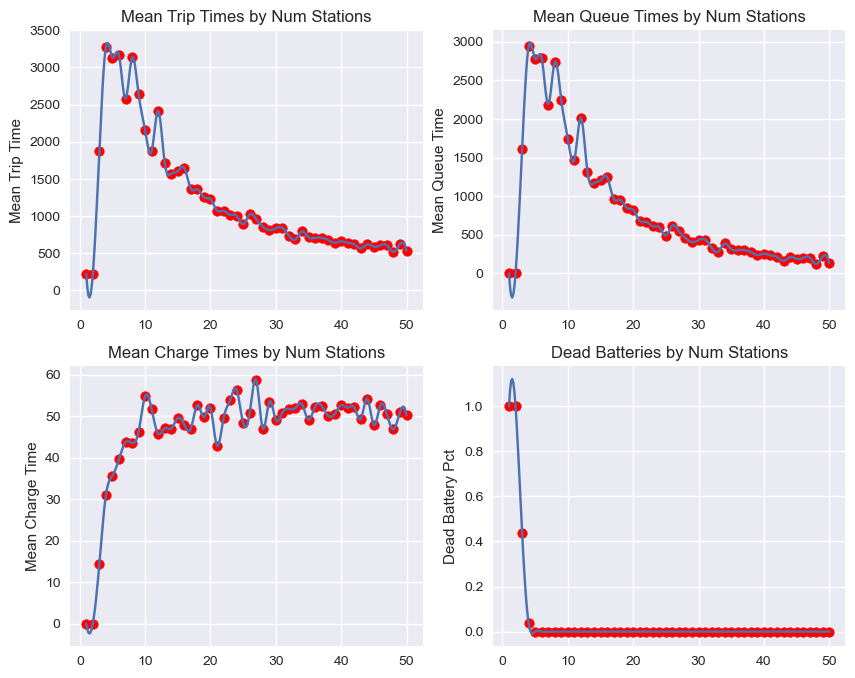

In [35]:
s2['sweep_plots']

In [36]:
vars(s2['sweep_params'])

{'sim_duration': 10080,
 'num_epochs': 5,
 'num_drivers': 1000,
 'num_stations': nan,
 'num_chargers': 5,
 'loc_destination': 616,
 'avg_speed': 104.585,
 'trip_time_tolerance': 0.3,
 'log_enabled': False}

In [ ]:
# Example 3: Single Scenario with optimized num_stations

In [ ]:
s3 = run_scenario(params=s2['sweep_params'])

In [37]:
s3 = run_scenario(num_drivers=1000, num_stations=50, num_epochs=25) 

Running scenario with these parameters:
sim_duration: 10080
num_epochs: 50
num_drivers: 1000
num_stations: 50
num_chargers: 5
loc_destination: 616
avg_speed: 104.585
trip_time_tolerance: 0.25
log_enabled: False


In [38]:
s3['driver_metrics']

{'avg_mileage': 616.0,
 'avg_trip_time': 571.6,
 'max_trip_time': 4700.8,
 'std_trip_time': 353.5,
 'ci_trip_time': (568.5, 574.7),
 'avg_queue_time': 165.2,
 'max_queue_time': 4205.3,
 'std_queue_time': 341.5,
 'ci_queue_time': (162.2, 168.1),
 'avg_charging_time': 53.0,
 'max_charging_time': 359.1,
 'std_charging_time': 30.9,
 'ci_charging_time': (164.9, 165.4),
 'avg_dead_batteries': 0.0}

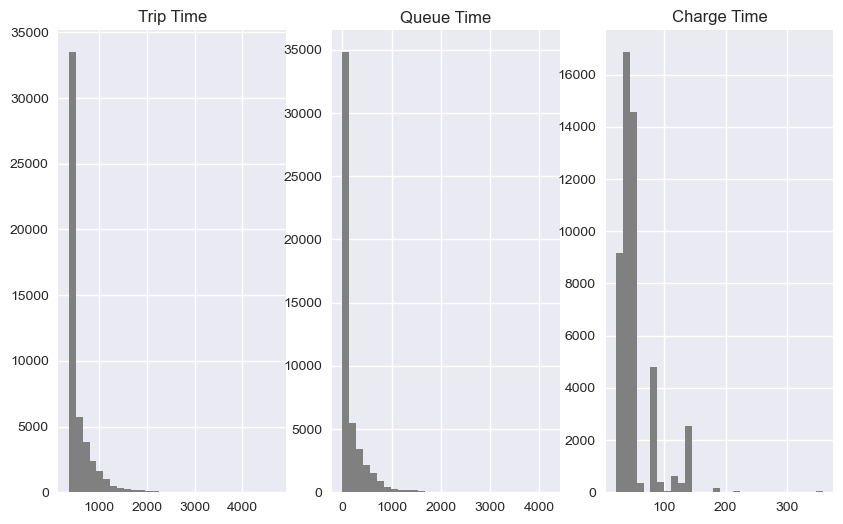

In [39]:
s3['driver_results_plot']

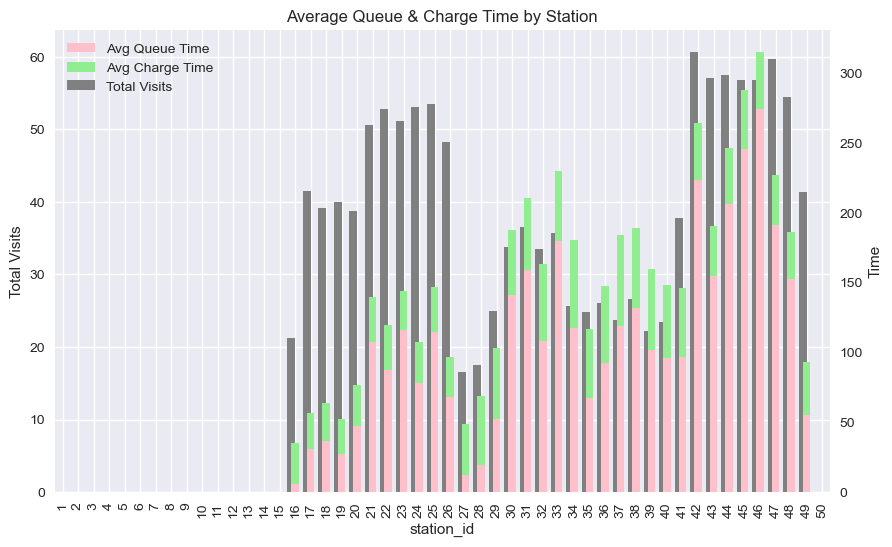

In [40]:
s3['station_metrics_plot']